In [13]:
import pandas as pd
import numpy as np
import scipy.sparse 
from scipy.sparse import csr_matrix
import math
import sparse
import ast
from tqdm import tqdm
import time
import csv
# from Preprocessing import *

import gurobipy as gp
from gurobipy import GRB

%store -r

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [14]:
#Create model and variables
upperbound=5
threshold=0.01
modell = gp.Model('Tours2'+str(threshold)+'ub'+str(upperbound))

yvar=modell.addVars(agents, vtype=GRB.CONTINUOUS, name="yvar")
xvar=modell.addVars(agents, lb=-1.0)
zvar=modell.addVar()
# yvar.start=1
Absolute_value=modell.addVars(zones,zones, vtype=GRB.CONTINUOUS, name="Absolute_value")

In [15]:
unusedthresholdpairs=[]
for i in tqdm((zones), desc="Creating constraints"):
    for j in zones:
        # if i==1 and j==4:
        #     constraint = modell.addConstr((gp.quicksum((yvar[a]*(prob[agents.index(a)][i,j])) for a in usedagents[(i,j)])) <= Absolute_value[i,j] + obsMatrix[j][i], name='constraint')
        # else:
        if sum(prob[agents.index(a)][i,j] for a in usedagents[(i,j)])>0:
            if obsMatrix[i][j]>threshold:
                modell.addConstr((gp.quicksum((yvar[a]*(prob[agents.index(a)][i,j])) for a in usedagents[(i,j)])) <= Absolute_value[i,j] + obsMatrix[j][i])
                modell.addConstr((gp.quicksum((yvar[a]*(prob[agents.index(a)][i,j])) for a in usedagents[(i,j)])) >= obsMatrix[j][i] - Absolute_value[i,j])
                modell.addConstr(Absolute_value[i,j]>=0)
            else:
                # print('hij heeft er nu eentje gevonden')
                unusedthresholdpairs.append([i,j])
        # else:
        #     modell.addConstr((gp.quicksum((yvar[a]*(prob[agents.index(a)][i,j])) for a in usedagents[(i,j)])) <= Absolute_value[i,j] + obsMatrix[j][i])
        #     modell.addConstr((gp.quicksum((yvar[a]*(prob[agents.index(a)][i,j])) for a in usedagents[(i,j)])) >= obsMatrix[j][i] - Absolute_value[i,j])
        #     modell.addConstr(Absolute_value[i,j]>=0)
modell.update()

Creating constraints: 100%|██████████| 696/696 [17:34<00:00,  1.51s/it]


In [16]:
# upperbound = 3

for a in agents: 
    modell.addConstr(yvar[a] >= 0)
    modell.addConstr(yvar[a]<= upperbound)
    modell.addConstr(xvar[a] == yvar[a]-1)
modell.addConstr(zvar==gp.norm(xvar,1))
modell.update()

In [17]:
# Objective function
obj = gp.quicksum((Absolute_value[i,j]) for i in zones for j in zones)+(1/maxagentnr)*zvar
modell.setObjective(obj, GRB.MINIMIZE)

In [18]:
# Run model
modell.write('tours2'+str(threshold)+'ub'+str(upperbound)+'.lp')
modell.optimize()
modell.write('solution'+str(threshold)+'ub'+str(upperbound)+'.sol')
end_time=time.time()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2048013 rows, 885431 columns and 2906436 nonzeros
Model fingerprint: 0x630f3cf9
Model has 1 general constraint
Variable types: 885431 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+03]
Presolve removed 2091750 rows and 766762 columns (presolve time = 5s) ...
Presolve removed 1801966 rows and 659858 columns
Presolve time: 8.63s
Presolved: 246047 rows, 225573 columns, 851849 nonzeros
Variable types: 225571 continuous, 2 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 1.51s

Barrier statistics:


In [19]:
#output report
ODmatrix={}
objective=0
quadobj=0
for i in tqdm(zones):
    for j in zones:
        if [i,j] in unusedthresholdpairs:
            ODmatrix[i+1,j+1]=abs(sum(yvar[a].x*prob[agents.index(a)][i,j] for a in usedagents[(i,j)])-obsMatrix[j][i])
            # extraobjective1+=abs(sum(prob[agents.index(a)][i,j] for a in usedagents[(i,j)])-obsMatrix[j][i])
            objective+=abs(sum(yvar[a].x*prob[agents.index(a)][i,j] for a in usedagents[(i,j)])-obsMatrix[j][i])
            quadobj+=(sum(yvar[a].x*prob[agents.index(a)][i,j] for a in usedagents[(i,j)])-obsMatrix[j][i])**2
        else:
            ODmatrix[i+1,j+1]=Absolute_value[i,j].x
            objective+=Absolute_value[i,j].x
            quadobj+=(Absolute_value[i,j].x)**2
        # print(f'The objective value for [{i+1},{j+1}] is {Absolute_value[i,j].x}')

print(f'The objective is {objective}')
print(f'The quadratic objective is {quadobj}')
print(f'The time before the model takes:{beforemodel_time-start_time}')
print(f'The time making the model takes:{end_time-beforemodel_time}')
print(f'The total time this takes:{end_time-start_time}')

y_variables=[]
variables={}
for a in agents:
    # print(f'The variable for agent {a} is {yvar[a].x}')
    y_variables.append(yvar[a].x)
    variables[a]=yvar[a].x

nonzerovaragent=[x for x in agents if variables[x]!=0]
# smallnonzeroagent=[x for x in nonzerovar if variables[x]<0.1]
zerovaragent=[a for a in agents if variables[a]==0]
nonzerovar=[x for x in y_variables if x!=0]
smallnonzero=[x for x in nonzerovar if x<0.1]
zerovar=[x for x in y_variables if x==0]
# print(zerovaragent)
print(f'The amount of nonzero values smaller than 0.1 is {len(smallnonzero)}')
# count=0    
small=[x for x in y_variables if x<5]
smallagents=[x for x in agents if variables[x]<5]
print(f'The number of nonzero variables is {len(nonzerovar)}')
print(f'The number of zero variables is {len(y_variables)-len(nonzerovar)}')
onesagent=[x for x in agents if variables[x]==1]
ones=[x for x in y_variables if x==1]

# print(ones)
print(f'number of ones is {len(ones)}')
largervalues=[x for x in agents if variables[x]>50]
print(f'number of largevalues is {len(largervalues)}')
# for i in range(0,len(nonzerovar)):
#     if nonzerovar[i]<5:
#         count+=1
        # print(nonzerovar[i])
print(f'The maximum value that a y variable takes is: {max(y_variables)} for agent: {y_variables.index(max(y_variables))+1}')
print(f'The amount of variables between 0 and 5 is: {len(small)}')

results={}
results['objective']=objective
results['starttime']=start_time
results['beforemodel_time']=beforemodel_time
results['end_time']=end_time
results['zerovar']=zerovaragent
results['ones']=onesagent
results['nonzerovar']=nonzerovaragent
results['amountnonzerovar']=len(nonzerovar)
results['variables>50']=largervalues
results['amountvariables>50']=len(largervalues)
results['agents<0.1']=smallagents
results['smallnonzero<0.1']=len(smallnonzero)
results['amountbetween0-5']=len(small)
results['maxyvalue']=max(y_variables)
results['y_variables']=y_variables

# open file for writing, "w" is writing
opener = open("results"+str(threshold)+'ub'+str(upperbound)+".csv", "w")
w= csv.writer(opener)

# loop over dictionary keys and values
for key, val in results.items():

    # write every key and value to file
    w.writerow([key, val])
opener.close()

np.savetxt("y_variables"+str(threshold)+'ub'+str(upperbound)+".csv", 
           y_variables,
           delimiter =", ", 
           fmt ='% s')
np.savetxt("agents"+str(threshold)+'ub'+str(upperbound)+".csv", 
           agents,
           delimiter =", ", 
           fmt ='% s')
var=pd.DataFrame([variables])
odmatrix=pd.DataFrame([ODmatrix])
var.to_csv('variables'+str(threshold)+'ub'+str(upperbound)+'.csv')
odmatrix.to_csv('ODMatrix'+str(threshold)+'ub'+str(upperbound)+'.csv')


100%|██████████| 696/696 [01:53<00:00,  6.16it/s]


The objective is 174398.99584534226
The quadratic objective is 10316043.020003978
The time before the model takes:875.3596587181091
The time making the model takes:19822.643738031387
The total time this takes:20698.003396749496
The amount of nonzero values smaller than 0.1 is 4274
The number of nonzero variables is 164723
The number of zero variables is 35784
number of ones is 109360
number of largevalues is 0
The maximum value that a y variable takes is: 5.0000000000000036 for agent: 69286
The amount of variables between 0 and 5 is: 192131


In [20]:
print(len(unusedthresholdpairs))

2252


run optimisation with upperbound 5, threshold 0.01


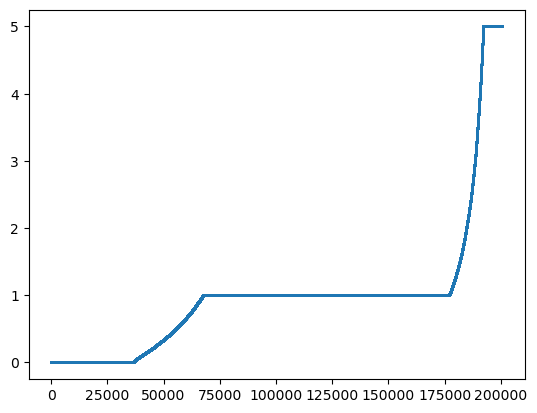

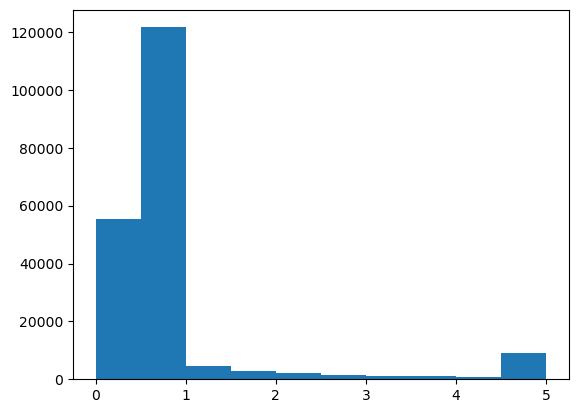

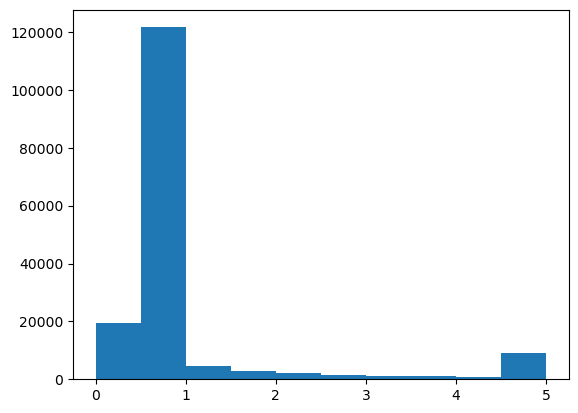

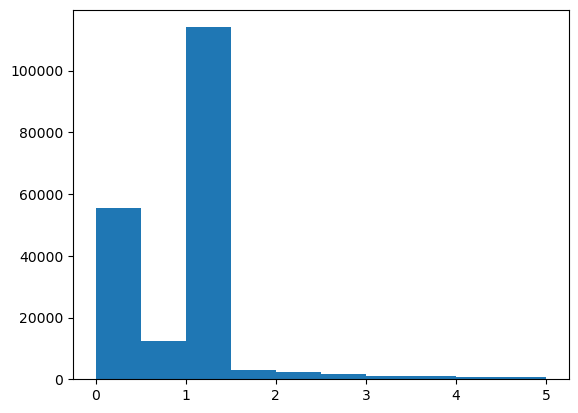

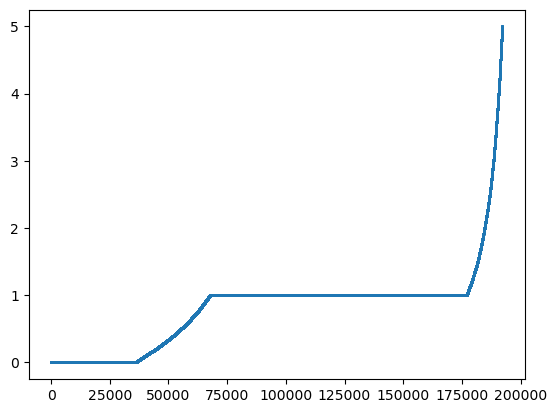

In [21]:
import matplotlib.pyplot as plt
print(f'run optimisation with upperbound {upperbound}, threshold {threshold}')
# plt.scatter(agents,y_variables.sort())
# plt.show()
# print(y_variables)
y_variables.sort()
# print(sortedlist)
plt.scatter(range(len(y_variables)),y_variables, s=1)
plt.savefig('plot'+str(threshold)+'ub'+str(upperbound)+'.png', dpi=500)
plt.show()
plt.hist(y_variables)
plt.savefig('histplot'+str(threshold)+'ub'+str(upperbound)+'.png', dpi=500)
plt.show()
plt.hist(nonzerovar)
plt.savefig('nonzerohist'+str(threshold)+'ub'+str(upperbound)+'.png', dpi=500)
plt.show()
plt.hist(small)
plt.savefig('smallvalues'+str(threshold)+'ub'+str(upperbound)+'.png', dpi=500)
plt.show()
small.sort()
plt.scatter(range(len(small)),small, s=1)
plt.savefig('smallscatter'+str(threshold)+'ub'+str(upperbound)+'.png', dpi=500)
plt.show()
# print(y_variables)